# Salicency Maps
The purpose of this notebook is to hold all code related to saliency maps.

Import packages that are needed

In [1]:
import os
import random
import torch

from torchvision import datasets, transforms
import matplotlib.pyplot as plt

from models.networks import get_model
from data_utils.data_stats import *
from utils.metrics import AverageMeter, real_acc
from torchmetrics import Accuracy

from models.resnet import resnet18
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [2]:
dataset = 'cifar10'                 # One of cifar10, cifar100, stl10, imagenet or imagenet21
architecture = 'B_6-Wi_1024'        # B_12-Wi_512
data_resolution = 32                # Resolution of data as it is stored
crop_resolution = 64                # Resolution of fine-tuned model (64 for all models we provide)
num_classes = CLASS_DICT[dataset]
eval_batch_size = 512
checkpoint = 'in21k_cifar10'        # This means you want the network pre-trained on ImageNet21k and finetuned on CIFAR10

In [3]:
torch.backends.cuda.matmul.allow_tf32 = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if not os.path.exists("checkpoints"):
    os.mkdir("checkpoints")

# Define the model and specify the pre-trained weights
model = get_model(architecture=architecture, resolution=crop_resolution, num_classes=num_classes, checkpoint=checkpoint)
model.to(device)

Weights already downloaded
Load_state output <All keys matched successfully>


BottleneckMLP(
  (linear_in): Linear(in_features=12288, out_features=1024, bias=True)
  (linear_out): Linear(in_features=1024, out_features=10, bias=True)
  (blocks): ModuleList(
    (0): BottleneckBlock(
      (block): Sequential(
        (0): Linear(in_features=1024, out_features=4096, bias=True)
        (1): GELU(approximate=none)
        (2): Linear(in_features=4096, out_features=1024, bias=True)
      )
    )
    (1): BottleneckBlock(
      (block): Sequential(
        (0): Linear(in_features=1024, out_features=4096, bias=True)
        (1): GELU(approximate=none)
        (2): Linear(in_features=4096, out_features=1024, bias=True)
      )
    )
    (2): BottleneckBlock(
      (block): Sequential(
        (0): Linear(in_features=1024, out_features=4096, bias=True)
        (1): GELU(approximate=none)
        (2): Linear(in_features=4096, out_features=1024, bias=True)
      )
    )
    (3): BottleneckBlock(
      (block): Sequential(
        (0): Linear(in_features=1024, out_features=

In [4]:
mean = MEAN_DICT[dataset]
std = STD_DICT[dataset]

transform = transforms.Compose([
    transforms.Resize((crop_resolution, crop_resolution)),
    transforms.ToTensor(),
])

In [5]:
cifar10_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

cifar10_classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

Files already downloaded and verified


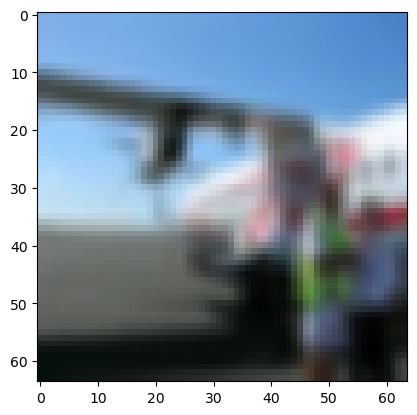

Picked image 1322


In [11]:
# select random test image
image_nr = random.randrange(len(cifar10_dataset))  # e.g., 6990 with FullGrad

# display image
image, true_label = cifar10_dataset[image_nr]
image_np = image.numpy().transpose((1, 2, 0))
plt.imshow(image_np)
plt.show()
print(f"Picked image {image_nr}")

# prepare image to be processed by model
image_model = transforms.Normalize(mean / 255., std / 255.)(image)
image_model = image_model.unsqueeze(0)
image_model = image_model.view(-1)
image_model = image_model.to(device)

In [7]:
model.eval()

with torch.no_grad():
    output = model(image_model)

probabilities = torch.nn.functional.softmax(output, dim=0)
predicted_class = torch.argmax(probabilities).item()

predicted_label = cifar10_classes[predicted_class]
true_y = cifar10_classes[true_label]

print(f"Model prediction: {predicted_label}")
print(f"True label:       {true_y}")

Model prediction: cat
True label:       cat


In [13]:
# Get the test loader
data_loader = torch.utils.data.DataLoader(cifar10_dataset,
                                          batch_size=eval_batch_size,
                                          shuffle=False,
                                          num_workers=2)

# Evaluate the model
model.eval()
total_acc = AverageMeter()
accuracy = Accuracy(task="multiclass", num_classes=10)

i = 0
with torch.no_grad():
    for ims, targs in data_loader:
        ims = transforms.Normalize(mean / 255., std / 255.)(ims)
        ims = torch.reshape(ims, (ims.shape[0], -1))
        preds = model(ims)
        probabilities = torch.nn.functional.softmax(preds, dim=0)
        predicted_class = torch.argmax(probabilities, dim=-1)
        acc = accuracy(predicted_class, targs)
        total_acc.update(acc, ims.shape[0])

print(total_acc.get_avg(percentage=True))

tensor(92.1600)


100%|██████████| 32/32 [01:46<00:00,  3.32s/it]


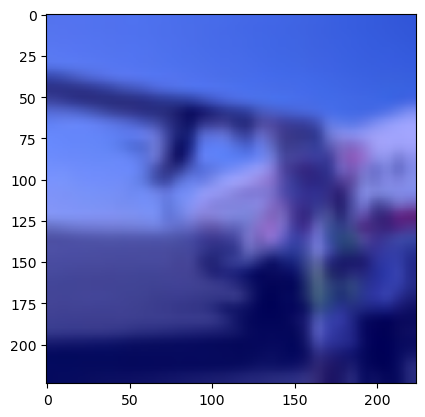

In [15]:
scaled_image = transforms.Resize((224, 224))(image)
scaled_image_np = scaled_image.numpy().transpose((1, 2, 0))

resnet_model = resnet18(pretrained=True)
target_layers = [resnet_model.layer4[-1]]

targets = [ClassifierOutputTarget(true_label)]
# GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
with ScoreCAM(model=resnet_model, target_layers=target_layers, use_cuda=False) as cam:
    model_image = transforms.Normalize(mean / 255., std / 255.)(scaled_image)
    grayscale_cam = cam(input_tensor=model_image.unsqueeze(0), targets=targets)

    # In this example grayscale_cam has only one image in the batch:
    grayscale_cam = grayscale_cam[0, :]

    visualization = show_cam_on_image(scaled_image_np, grayscale_cam, use_rgb=True)
    plt.imshow(visualization)
    plt.show()